In [2]:
# -----------------------------
# 0. Imports & global config
# -----------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (12, 5)

DATA_PATH   = Path(r"C:\Users\btulu\OneDrive - University of Florida\Class\UF_Class\Summer_2025\10Academy\week0_projects\solar-challenge-week1\notebooks\10 academy\solar-challenge-week1\data")
CLEAN_PATH  = DATA_PATH / "cleaned"
CLEAN_PATH.mkdir(exist_ok=True)                 # folder for cleaned CSVs

CSV_FILES   = {
    "benin"        : "benin-malanville.csv",
    "sierraleone"  : "sierraleone-bumbuna.csv",
    "togo"         : "togo-dapaong_qc.csv",
}

KEY_COLS    = ['GHI','DNI','DHI','ModA','ModB','WS','WSgust']

# -----------------------------
# 1. Helper functions
# -----------------------------
def load_csv(tag):
    """Load a raw CSV and parse Timestamp."""
    fp = DATA_PATH / CSV_FILES[tag]
    df = pd.read_csv(fp, parse_dates=['Timestamp'])
    df['country'] = tag                    # add origin tag for later concatenation
    return df

def iqr_outlier_mask(series, k=1.5):
    """Return a boolean mask where True = outlier via IQR method."""
    q1, q3 = series.quantile([0.25, 0.75])
    iqr    = q3 - q1
    lower  = q1 - k*iqr
    upper  = q3 + k*iqr
    return (series < lower) | (series > upper)

def clean_df(df):
    """Remove IQR outliers & impute NA with median; drop Comments col if present."""
    mask = pd.DataFrame({col: iqr_outlier_mask(df[col]) for col in KEY_COLS}).any(axis=1)
    df   = df.loc[~mask].copy()

    # median imputation for numeric NaNs
    num_medians = df.median(numeric_only=True)
    df.fillna(num_medians, inplace=True)

    # drop 'Comments' if exists
    if 'Comments' in df.columns:
        df = df.drop(columns=['Comments'])
    return df

def save_clean(df, tag):
    """Write cleaned CSV."""
    out = CLEAN_PATH / f"{tag}-clean.csv"
    df.to_csv(out, index=False)

def monthly_aggregate(df):
    """Return monthly mean of key irradiance + temp cols."""
    df = df.copy()
    df['month'] = df['Timestamp'].dt.month
    return df.groupby('month')[['GHI','DNI','DHI','Tamb']].mean()

# -----------------------------
# 2. Load, clean, export
# -----------------------------
cleaned = {}             # store cleaned frames by tag
summary = {}             # quick summaries for each

for tag in CSV_FILES:
    raw      = load_csv(tag)
    clean    = clean_df(raw)
    save_clean(clean, tag)
    cleaned[tag] = clean

    summary[tag] = {
        "rows_raw"   : len(raw),
        "rows_clean" : len(clean),
        "outlier_pct": 100 * (1 - len(clean)/len(raw)),
        "na_after"   : clean.isna().sum().sum()
    }

pd.DataFrame(summary).T   # quick glance table


,rows_raw,rows_clean,outlier_pct,na_after
benin,525600.0,494920.0,5.837139,0.0
sierraleone,525600.0,417347.0,20.596081,0.0
togo,525600.0,460499.0,12.386035,0.0


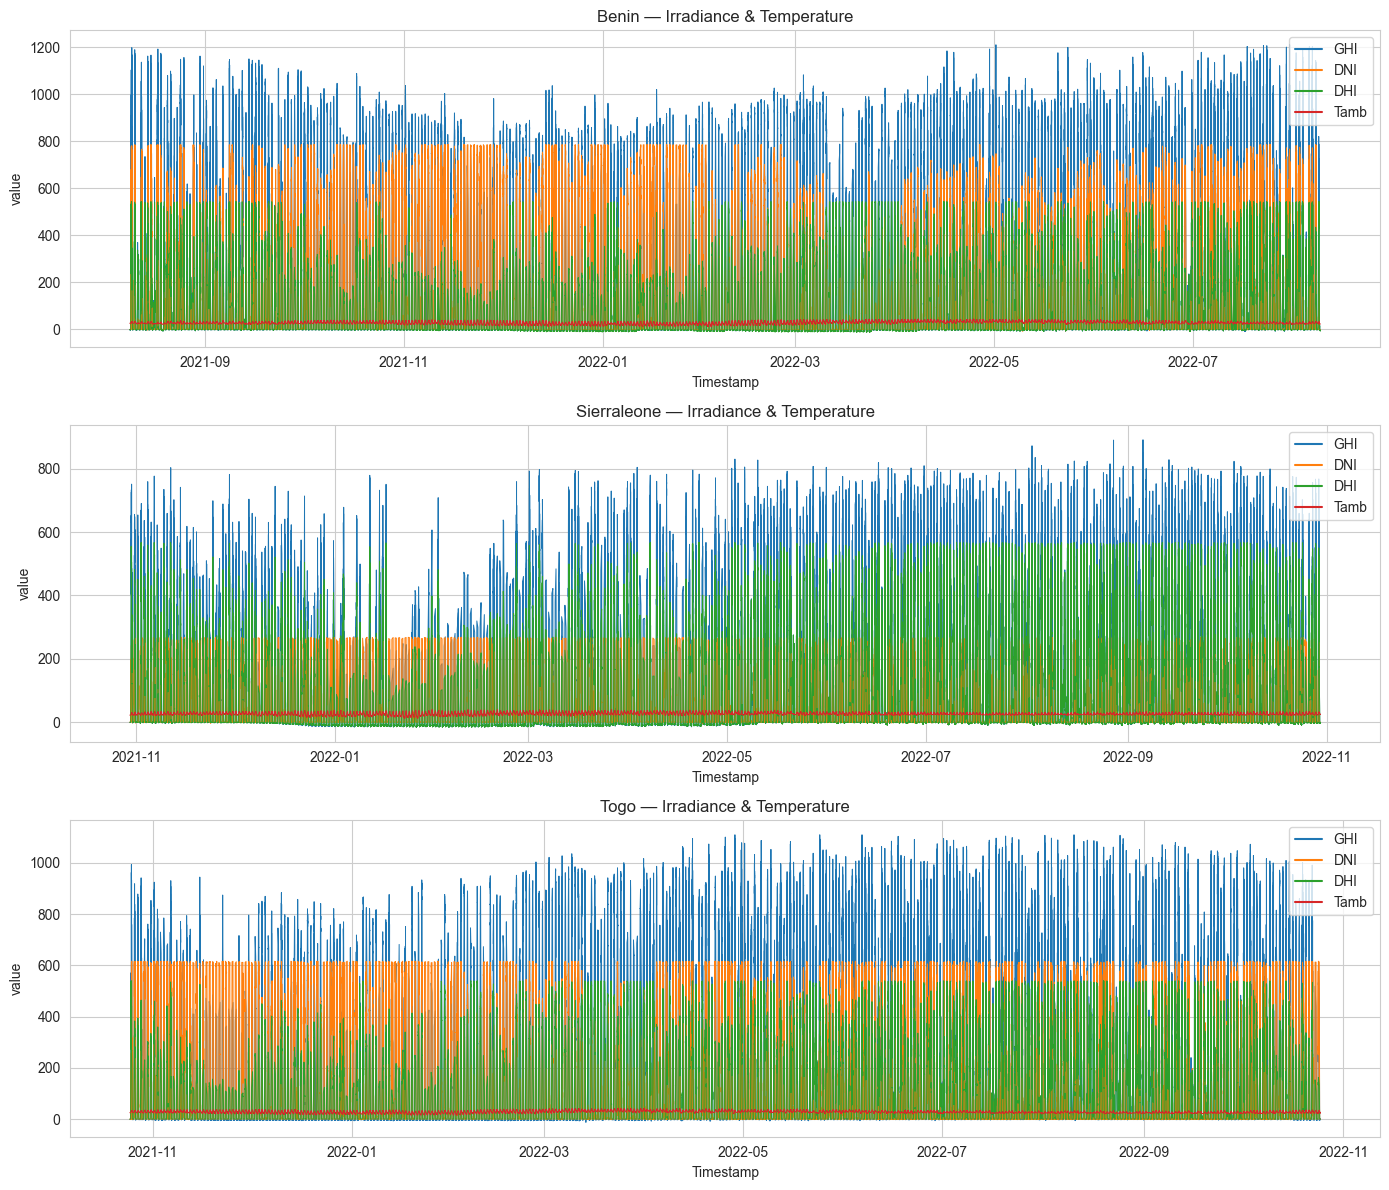

In [3]:
fig, axes = plt.subplots(3, 1, figsize=(14, 12), sharex=False)
for ax, (tag, df) in zip(axes, cleaned.items()):
    # pivot longer so Seaborn can plot multiple lines easily
    long = df.melt(id_vars='Timestamp', value_vars=['GHI','DNI','DHI','Tamb'],
                   var_name='variable', value_name='value')
    sns.lineplot(data=long, x='Timestamp', y='value', hue='variable',
                 ax=ax, linewidth=0.7)
    ax.set_title(f"{tag.capitalize()} — Irradiance & Temperature")
    ax.legend(loc='upper right')
plt.tight_layout()


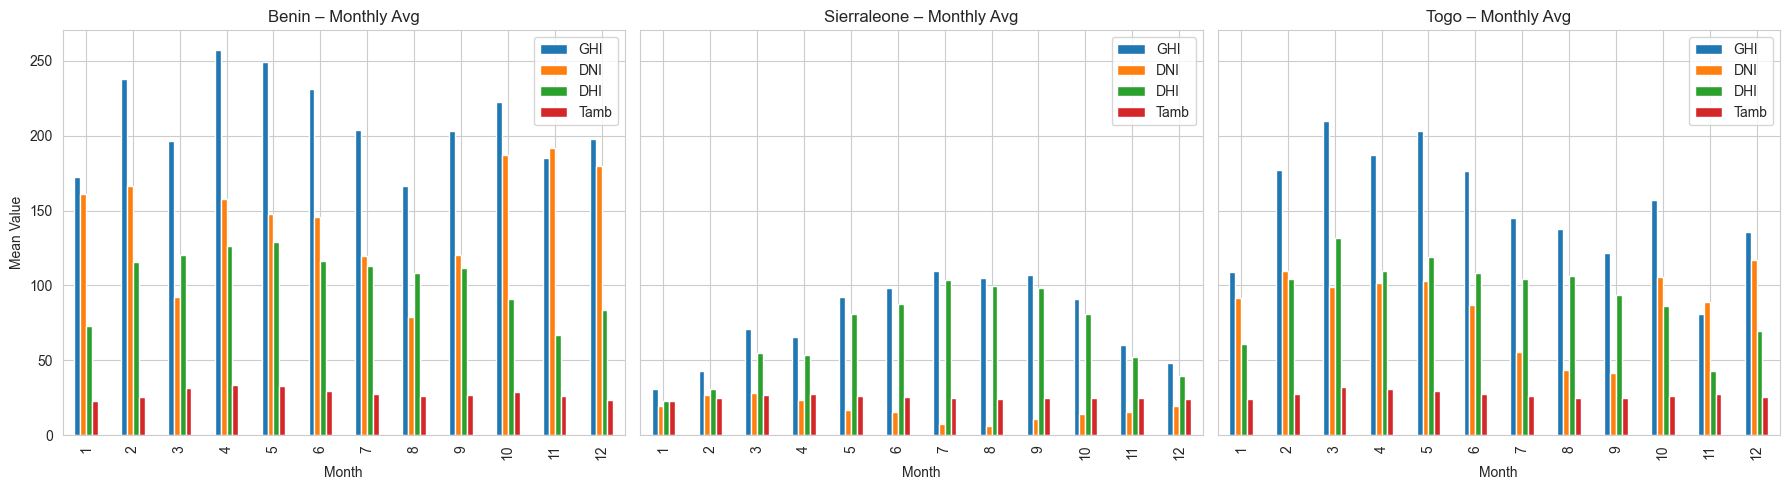

In [4]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)
for ax, (tag, df) in zip(axes, cleaned.items()):
    monthly = monthly_aggregate(df)
    monthly.plot(kind='bar', ax=ax)
    ax.set_title(f"{tag.capitalize()} – Monthly Avg")
    ax.set_xlabel("Month")
    ax.set_ylabel("Mean Value")
plt.tight_layout()


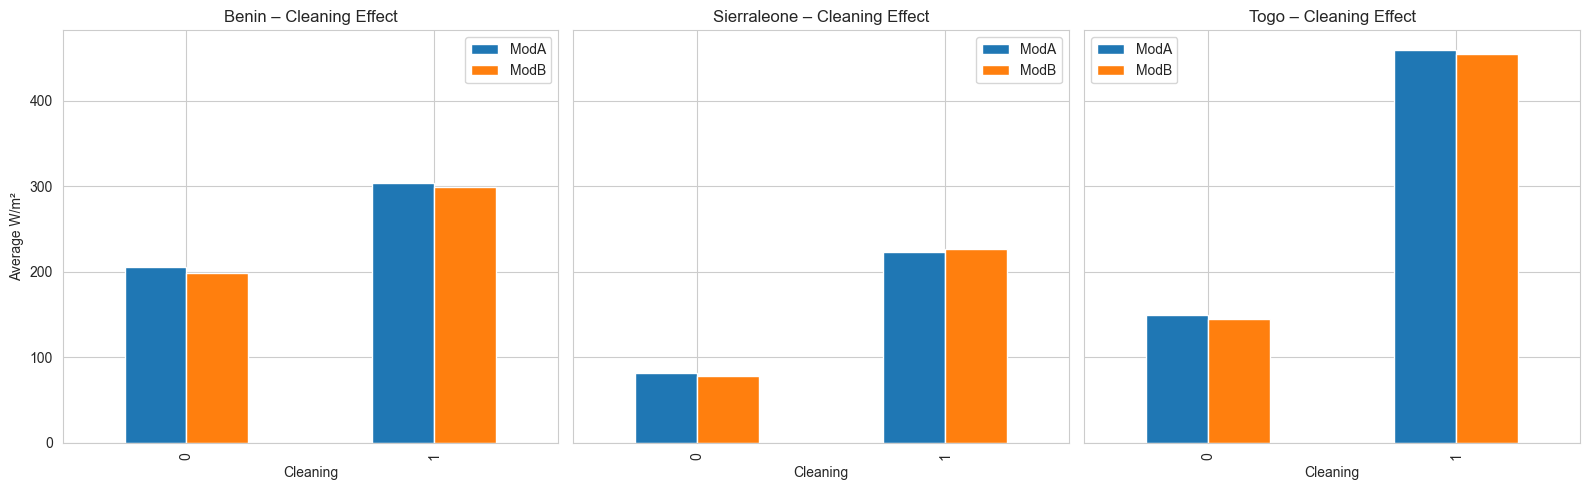

In [5]:
fig, axes = plt.subplots(1, 3, figsize=(16,5), sharey=True)
for ax, (tag, df) in zip(axes, cleaned.items()):
    impact = df.groupby('Cleaning')[['ModA','ModB']].mean()
    impact.plot(kind='bar', ax=ax, title=f"{tag.capitalize()} – Cleaning Effect")
    ax.set_ylabel("Average W/m²")
plt.tight_layout()


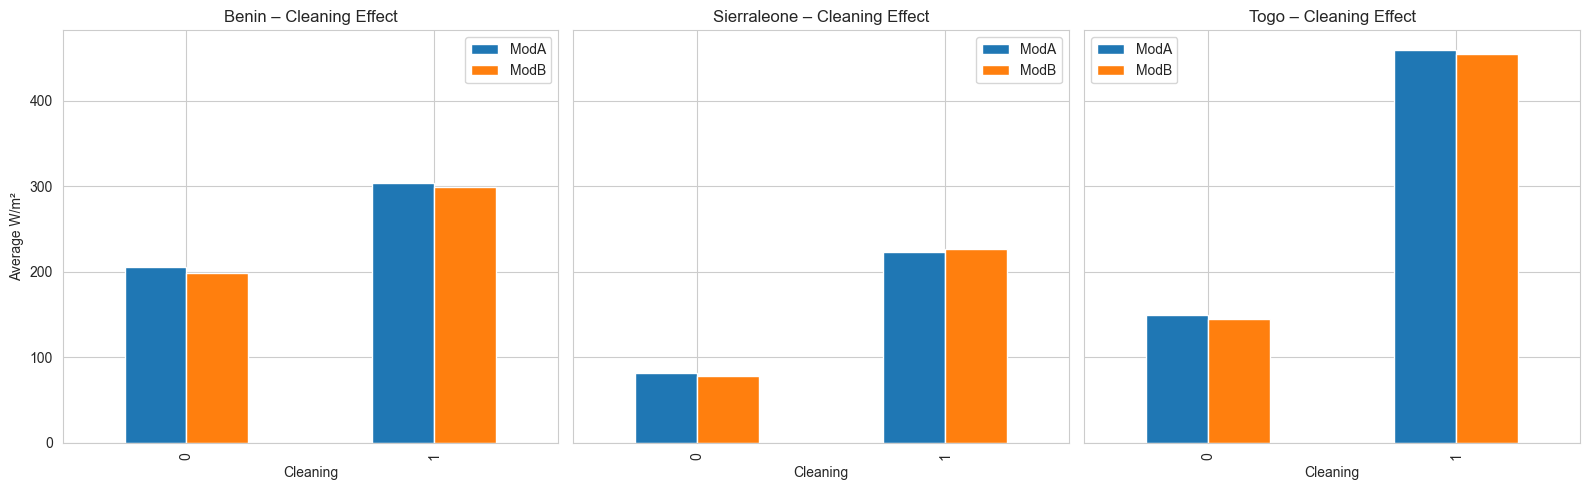

In [6]:
fig, axes = plt.subplots(1, 3, figsize=(16,5), sharey=True)
for ax, (tag, df) in zip(axes, cleaned.items()):
    impact = df.groupby('Cleaning')[['ModA','ModB']].mean()
    impact.plot(kind='bar', ax=ax, title=f"{tag.capitalize()} – Cleaning Effect")
    ax.set_ylabel("Average W/m²")
plt.tight_layout()


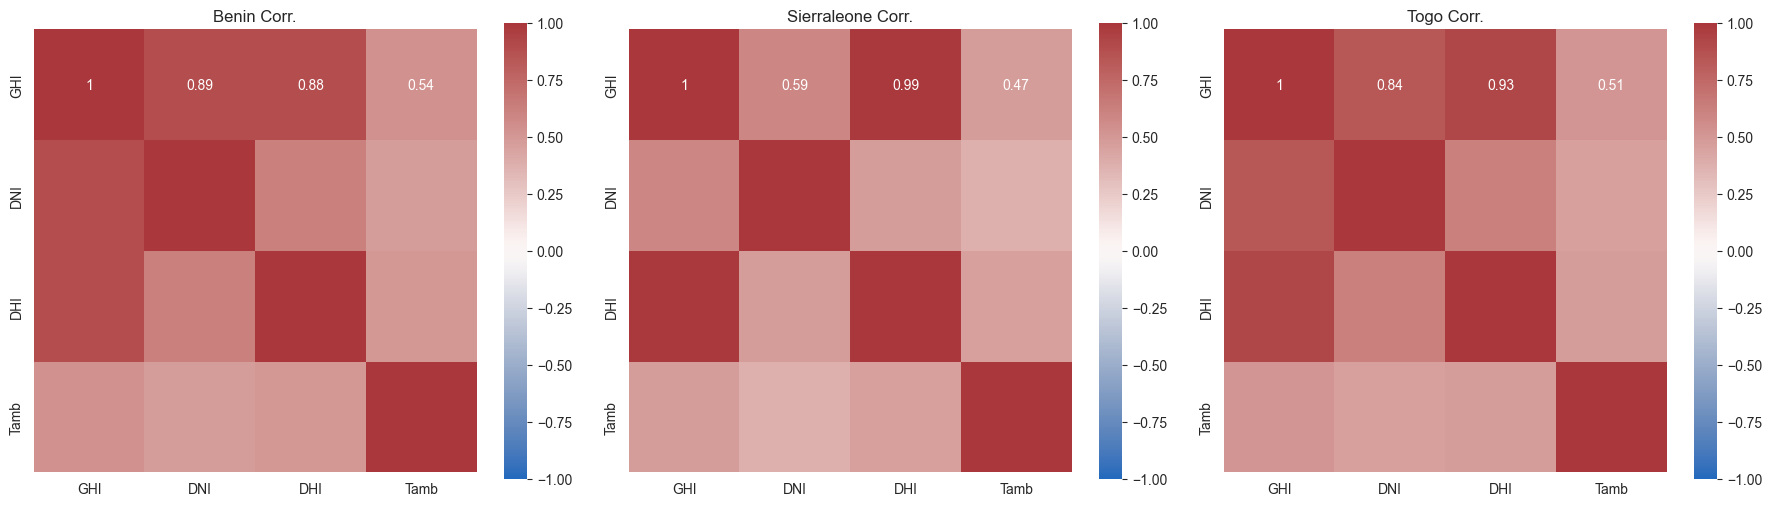

In [7]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for ax, (tag, df) in zip(axes, cleaned.items()):
    corr = df[['GHI','DNI','DHI','Tamb']].corr()
    sns.heatmap(corr, annot=True, cmap="vlag", vmin=-1, vmax=1, ax=ax, square=True)
    ax.set_title(f"{tag.capitalize()} Corr.")
plt.tight_layout()


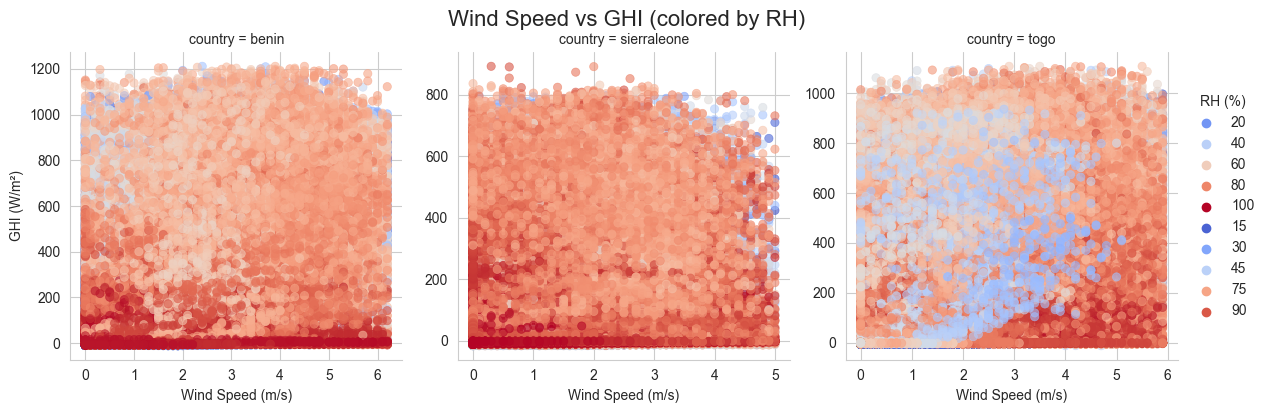

In [8]:
g = sns.FacetGrid(
        pd.concat(cleaned.values()),
        col="country", col_wrap=3, height=4, sharex=False, sharey=False)
g.map_dataframe(
        sns.scatterplot, x='WS', y='GHI', hue='RH',
        palette="coolwarm", alpha=0.6, edgecolor=None)
g.add_legend(title="RH (%)")
g.set_axis_labels("Wind Speed (m/s)", "GHI (W/m²)")
g.fig.suptitle("Wind Speed vs GHI (colored by RH)", y=1.02, fontsize=16)
plt.show()


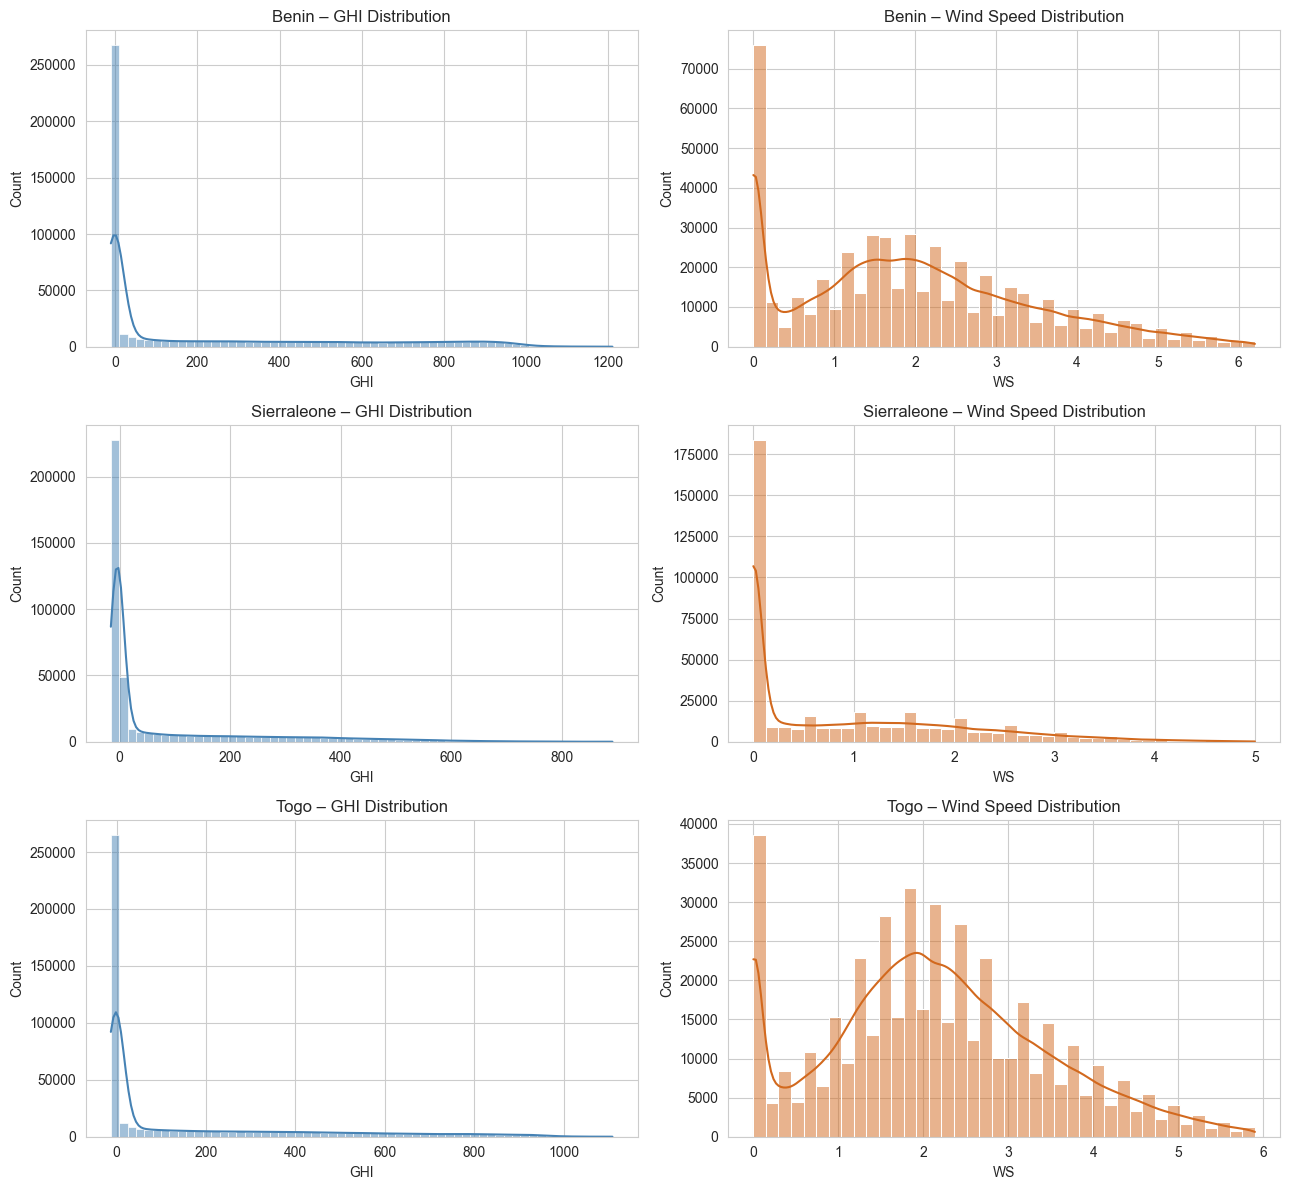

In [9]:
fig, axes = plt.subplots(3, 2, figsize=(13, 12))
for r, (tag, df) in enumerate(cleaned.items()):
    sns.histplot(df['GHI'], bins=60, ax=axes[r,0], color='steelblue', kde=True)
    axes[r,0].set_title(f"{tag.capitalize()} – GHI Distribution")
    sns.histplot(df['WS'], bins=40, ax=axes[r,1], color='chocolate', kde=True)
    axes[r,1].set_title(f"{tag.capitalize()} – Wind Speed Distribution")
plt.tight_layout()


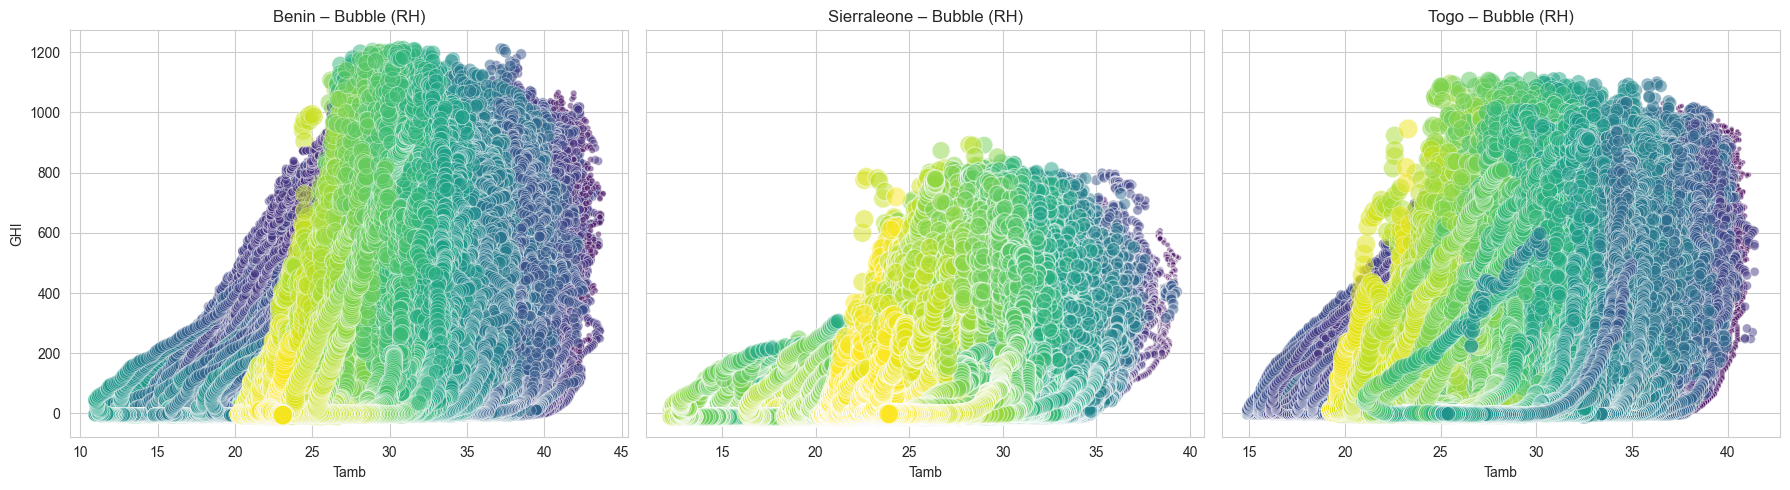

In [10]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)
for ax, (tag, df) in zip(axes, cleaned.items()):
    sns.scatterplot(data=df, x="Tamb", y="GHI",
                    size="RH", hue="RH",
                    palette="viridis", sizes=(10, 200), alpha=0.5, ax=ax)
    ax.set_title(f"{tag.capitalize()} – Bubble (RH)")
    ax.legend([],[], frameon=False)  # hide duplicate legends
plt.tight_layout()


<Figure size 600x600 with 0 Axes>

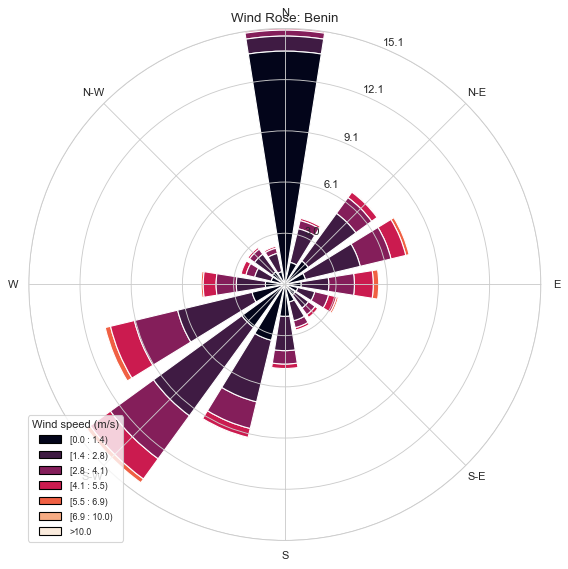

<Figure size 600x600 with 0 Axes>

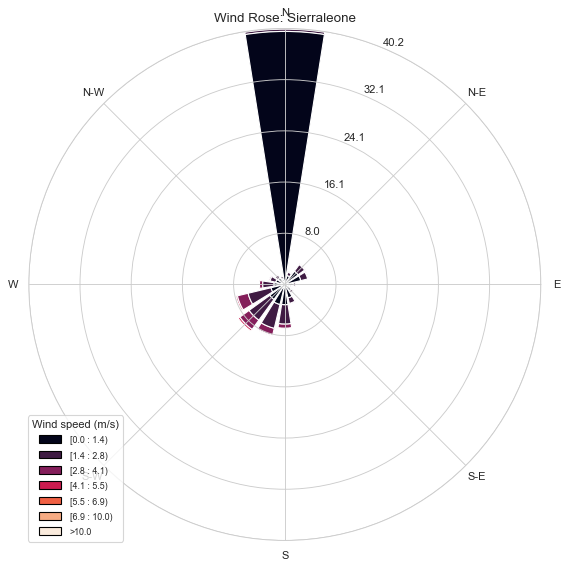

<Figure size 600x600 with 0 Axes>

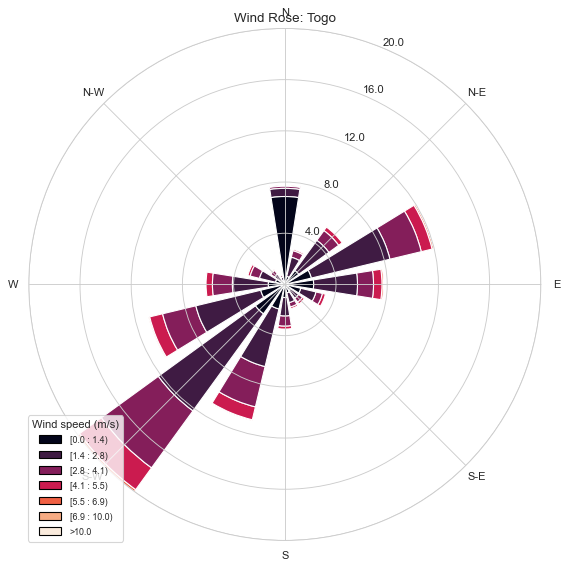

In [13]:
import matplotlib.pyplot as plt
from windrose import WindroseAxes

# Loop over each country tag and its cleaned DataFrame
for tag, df_country in cleaned.items():
    # Create a new figure and windrose axes
    fig = plt.figure(figsize=(6, 6))
    ax = WindroseAxes.from_ax()

    # Plot the windrose “bar” style
    ax.bar(
        df_country['WD'],         # Wind direction
        df_country['WS'],         # Wind speed
        normed=True,              # Show % distribution
        opening=0.8,              # Spacing between bars
        edgecolor='white',        # White edges
        bins=[0, 1.4, 2.8, 4.1, 5.5, 6.9, 10]  # Example bins; adjust as needed
    )

    # Add legend and title
    ax.set_legend(title='Wind speed (m/s)')
    ax.set_title(f"Wind Rose: {tag.capitalize()}")

    # Finally, show or save the plot
    plt.show()


In [12]:
!pip install windrose

Defaulting to user installation because normal site-packages is not writeable
